In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import os, random                 
import seaborn as sns                          
import keras 
import matplotlib.pyplot as plt
import h5py

from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import image  
from keras.models import Sequential    
from keras.layers import  Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input                               
from keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception     
from keras import regularizers                           
from keras.optimizers import Adam,RMSprop,SGD,Adamax                        
from keras import layers                                 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

print("Importações e dependencias adicionadas com sucesso.")

Importações e dependencias adicionadas com sucesso.


### DataPath

Contagem do número de ficheiros e quantidade de imagens em cada classe de doença de pele (**Urticaria**, **Psoriasis**, **Lupus**, **Dermatite**, **Melanoma**).

| Classe de Doença de Pele                                     | Conjunto de Treino | Conjunto de Teste |
|---------------------------------------------------------------|--------------------|-------------------|
| URTICARIA HIVES                                              | 416                | 53                |
| PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES        | 483                | 350               |
| LUPUS AND OTHER CONNECTIVE TISSUE DISEASES                   | 416                | 105               |
| ATOPIC DERMATITIS PHOTOS                                     | 483                | 123               |
| MELANOMA SKIN CANCER NEVI AND MOLES                          | 453                | 115               |

Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 489
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 420
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 463
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 1405
Total number of images in [URTICARIA HIVES] in train set: 212
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 116
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 352
Total number of images in [URTICARIA HIVES] in test set: 53
['Atopic Dermatitis Photos', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis pictures Lichen Planus and related diseases', 'Urticaria Hives']


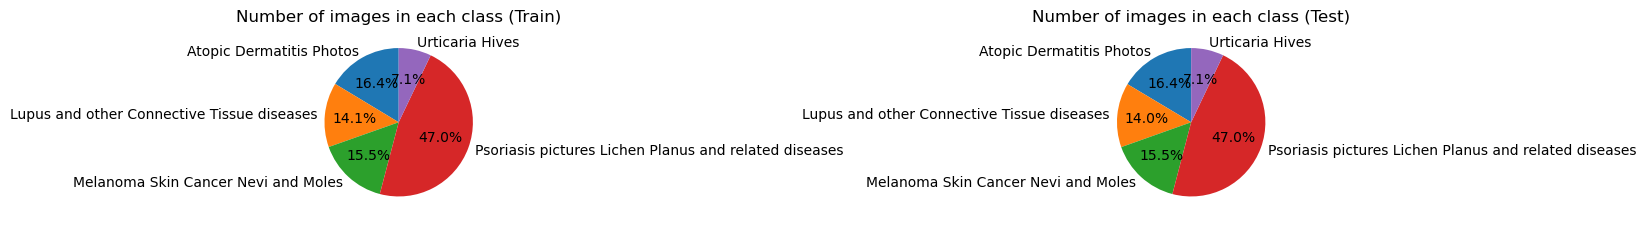

In [2]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
#train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
#test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

train_folder= 'C:/Dev/DatasetMEIA/train'
test_folder = 'C:/Dev/DatasetMEIA/test'


# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

y=list(train_diseases.keys())
print(y)

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

## Defnição de funções 

### Obtenção dos Dados de Treino, Validação e Teste

Definição de uma função para obter os dados de treino, validação e teste.

#### Funcionalidades Principais:

- **Função `get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32)`:** Retorna geradores de dados para treino, validação e teste.
- **Pré-processamento dos Dados de Treino:** Utiliza `ImageDataGenerator` para aplicar transformações nos dados de treino, como redimensionamento, normalização e aumento de dados.
- **Divisão em Conjuntos de Treino e Validação:** Divide os dados de treino em conjuntos de treino e validação.
- **Pré-processamento dos Dados de Teste:** Aplica redimensionamento e normalização nos dados de teste.
- **Geradores de Dados:** Cria geradores de dados para treino, validação e teste, utilizando as configurações definidas.


In [3]:
import os

def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # Fixando a divisão em 80% treino e 20% validação
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    # Carregar dados de treinamento e validação
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Define o subset como treinamento
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Define o subset como validação
        seed=10
    )

    # Obtendo o mapeamento de classes para índices
    class_indices = train_generator.class_indices

    # Invertendo o mapeamento para obter índices para classes
    indices_class = {v: k for k, v in class_indices.items()}

    # Inicializando um contador para cada classe
    class_counts_train = {class_name: 0 for class_name in indices_class.values()}

    # Iterando sobre o diretório de treinamento e contando o número de imagens em cada classe
    for class_name in class_counts_train.keys():
        class_folder = os.path.join(train_folder, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts_train[class_name] = num_images

    # Data augmentation para o conjunto de teste
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de teste
    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtendo o número de imagens por classe no conjunto de teste
    class_counts_test = {class_name: len(os.listdir(os.path.join(test_folder, class_name))) for class_name in class_counts_train.keys()}

    # Obtendo o número de imagens por classe no conjunto de validação
    class_counts_validation = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_counts_train.keys()}

    # Imprimindo o número de imagens para cada classe no conjunto de validação
    print("\nNúmero de imagens por classe no conjunto de validação:")
    for class_name, count in class_counts_validation.items():
        print(f"Classe: {class_name}, Número de Imagens: {count}")
    
    return train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation

train_generator, validation_generator, _, class_counts_train, class_counts_test,class_counts_validation = get_data(train_folder, test_folder)

# Imprimindo o número de imagens para cada classe no conjunto de treinamento
print("Número de imagens por classe no conjunto de treinamento:")
for class_name, count in class_counts_train.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de validação
print("\nNúmero de imagens por classe no conjunto de validação:")
for class_name, count in class_counts_validation.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de teste
print("\nNúmero de imagens por classe no conjunto de teste:")
for class_name, count in class_counts_test.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")


Found 2393 images belonging to 5 classes.
Found 596 images belonging to 5 classes.
Found 749 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 489
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 420
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 463
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 1405
Classe: Urticaria Hives, Número de Imagens: 212
Número de imagens por classe no conjunto de treinamento:
Classe: Atopic Dermatitis Photos, Número de Imagens: 489
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 420
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 463
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 1405
Classe: Urticaria Hives, Número de Imagens: 212

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Núm

### Treino dos Modelos

Definição de uma função para treinar os modelos de classificação.

#### Funcionalidades Principais:

- **Função `train_model(model, train_generator, validation_generator, epochs)`:** Compila e treina o modelo de classificação.
- **Compilação do Modelo:** Utiliza o otimizador 'adam' e a função de perda 'categorical_crossentropy' para compilar o modelo. Além disso, utiliza a métrica de accuracy e precisão durante o treino.
- **Treinoo do Modelo:** Treina o modelo utilizando os geradores de dados de treino e validação, durante o número especificado de épocas.
- **Retorno do Modelo e Histórico:** Retorna o modelo treinado e o histórico de treino.


In [4]:
# Função para treinar os modelos
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

### Avaliação dos Modelos

Definição de uma função para avaliar o desempenho dos modelos.

#### Funcionalidades Principais:

- **Função `evaluate_model(model, history, test_generator, test_folder)`:** Avalia o modelo de classificação.
- **Previsões:** Utiliza o modelo para fazer previsões sobre os dados de teste.
- **Conversão das Previsões para Rótulos:** Converte as previsões em rótulos para comparação com os rótulos verdadeiros.
- **Cálculo da Precisão, Recall e AUC:** Calcula a precisão, recall e AUC do modelo utilizando as previsões e os rótulos verdadeiros.
- **Visualização dos Resultados:** Plot da precisão, recall, AUC, bem como a precisão e perda de treino e validação em cada época.

In [5]:
# Função para avaliar os modelos
from sklearn.metrics import precision_score, recall_score, accuracy_score

def evaluate_model(model, history, test_generator, test_folder): 
    # Prever
    y_pred = model.predict(test_generator)

    # Converter as previsões em rótulos
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calcular precisão, recall e exatidão
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # O cálculo da AUC não é possível sem y_score (probabilidades de classe)
    # auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted', multi_class='ovr')

    # Gráfico da precisão e perda de treino e validação em cada época
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    # Gráfico da precisão de treino e validação do modelo
    plt.plot(history.history['accuracy'], label='Precisão de Treino')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico da perda de treino e validação em cada época
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    # print("AUC:", auc)

    plt.show()

### Guardar os Modelos

Definição de uma função para salvar os modelos treinados, juntamente com sua avaliação e histórico de treino.

#### Funcionalidades Principais:

- **Função `save_model(model, model_name, history, train_folder)`:** Salva o modelo treinado, sua avaliação e histórico de treinamento.
- **Criação de Pastas:** Cria pastas para salvar o modelo, a avaliação e o histórico, se não existirem.
- **Salvamento do Modelo:** Salva o modelo treinado em formato h5.
- **Avaliação do Modelo:** Avalia o modelo e salva a avaliação em uma figura.
- **Salvamento da Arquitetura do Modelo:** Plota e salva a arquitetura do modelo em uma imagem.
- **Salvamento do Histórico de Treinamento:** Salva o histórico de treinamento em um arquivo CSV.


In [6]:
# Função para guardar os modelos
def save_model(model, model_name, history, train_folder, test_folder, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

## Modelos

### CNN 2D

Found 2393 images belonging to 5 classes.
Found 596 images belonging to 5 classes.
Found 749 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 489
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 420
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 463
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 1405
Classe: Urticaria Hives, Número de Imagens: 212
24/24 [==============================] - 20s 845ms/step
Precision: 0.22086235140400817
Recall: 0.4699599465954606
Accuracy: 0.4699599465954606


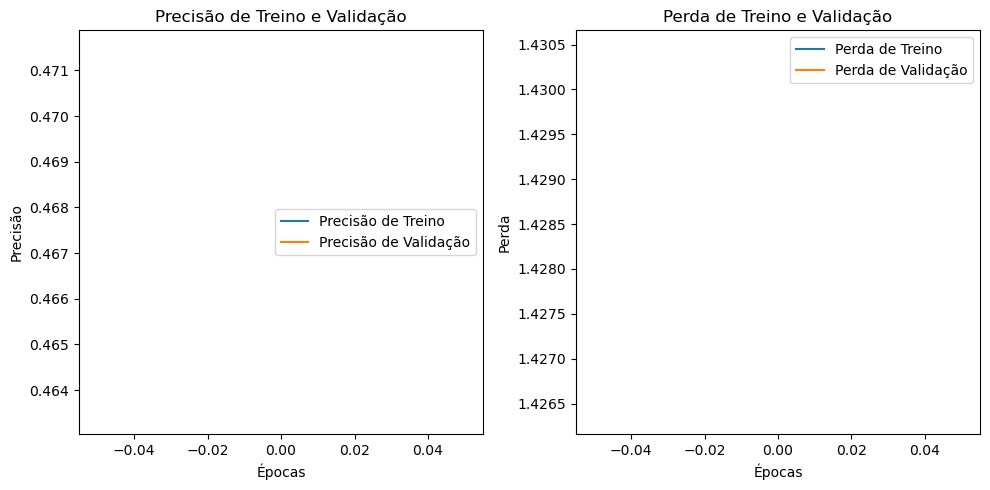

24/24 [==============================] - 14s 557ms/step


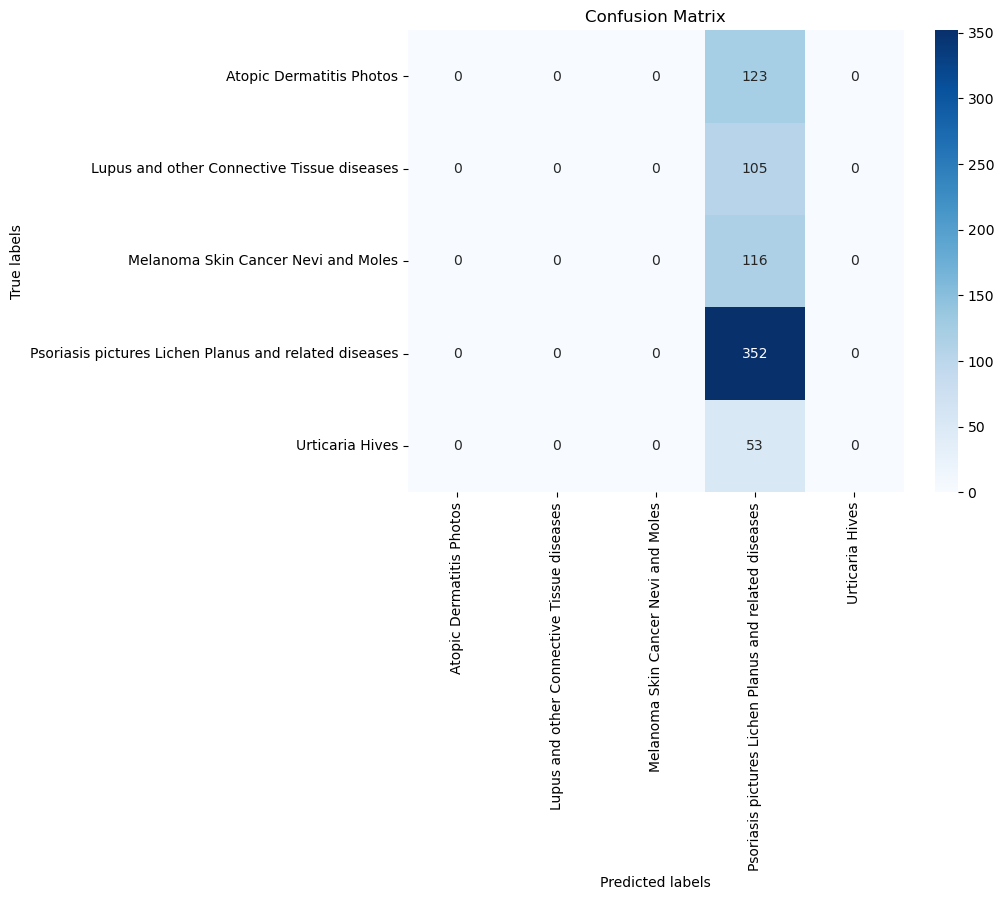


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.00      0.00      0.00       123
           Lupus and other Connective Tissue diseases       0.00      0.00      0.00       105
                  Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00       116
Psoriasis pictures Lichen Planus and related diseases       0.47      1.00      0.64       352
                                      Urticaria Hives       0.00      0.00      0.00        53

                                             accuracy                           0.47       749
                                            macro avg       0.09      0.20      0.13       749
                                         weighted avg       0.22      0.47      0.30       749


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 0
Verdadeiros Negativos: 0
Falsos Positivos: 0
Falsos Negativo

C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Definição da arquitetura da CNN
def CNN_model(input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

    return model

# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=1):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo CNN
    model = CNN_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN), 
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

    # Guardar o modelo
    #save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

# Execução do modelo CNN
run_cnn_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = CNN_model()

# Sumário do modelo
model.summary()

### ResNet50

In [ ]:
# Definição da arquitetura da ResNet
def ResNet_model(input_shape=(250, 250, 3)):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=1):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo ResNet
    model = ResNet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN), 
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)
    
    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo ResNet
run_resnet_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

### VGG16

In [ ]:
# Função para definir a arquitetura do modelo VGG16
def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Redimensionar as imagens de entrada para 224x224 para corresponder à forma de entrada do VGG16
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importar o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Remover a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Camada de saída
    x = Flatten()(vgg16_layer)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

from sklearn.metrics import confusion_matrix, classification_report

# Execução do modelo VGG16
def run_vgg16_model(train_folder, test_folder, epochs=1):
    # Obtenção de dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo VGG16
    model = VGG16_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN), 
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)
    
    # Guardar o modelo
    save_model(model, 'VGG16_model', history, train_folder, test_folder, test_generator)

# Execução do modelo VGG16
run_vgg16_model(train_folder, test_folder)


In [ ]:
# Obter o modelo
model = VGG16_model()

# Sumário do modelo 
model.summary()